In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pdb

## 【問題1】中心点の初期値を決める
入力されたデータから $ K $ 個の中心点 $ μ1 $ から $ μ_K $ の初期値を決めるコードを作成してください。  
$ K $ は指定したクラスタ数です。  
最もシンプルな初期値の決定方法は、データ点 $ X_n $ の中からランダムに $ K $ 個選ぶことです。今回はこれを実装してください。  
K-meansの学習結果は中心点 $ μ $ の初期値に影響を受けます。  
そのため、学習時には複数個の初期値で計算を行います。

## 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。  
K-meansはこのSSEを最小化する $ r_{nk} $ と $ μ_k $ を求めることが目的となります。  
複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。
$$
SSE = \sum^{N}_{n=1} \sum^{K}{k=1}r_{nk} |X_n - \mu_k|^2
$$

## 【問題3】クラスタへの割り当て
全てのデータ点 $X_n $ を最も近い中心点 $ μ_k $ に割り当てるコードを作成してください。  
K-menasにおける **近い** とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル $ p, q $ に対しては以下の数式で表現できます。
$$
|q - p| = \sqrt{(q-p)\cdot(q-p)}
$$

## 【問題4】中心点の移動
中心点 $ μ_k $ を $ k $ 番目のクラスタに割り当てられる全てのデータ点 $ X_n $ の平均値（重心）に移動するコードを作成してください。  
クラスタの割り当て $ r_{nk} $ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

## 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。  
次のどれかの条件を満たしたらこれを止めます。
- 繰り返しが指定した回数に到達する。（雛形では引数max_iter）
- 中心点 $ μ_k $ と重心の差が指定した許容値以下になる。（雛形では引数tol）

## 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。  
複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 $ μ_k $ を保持しておきます。

## 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。  
- データ点 $ X_n $ と学習で決まった中心点 $ μ_k $ に対し、SSEを最小化する $ r_{nk} $  を選ぶ。  

具体的には次のことです。

- データ点 $ X_n $ を最も近い $ μ_k $ に割り当てる。

In [2]:
class ScratchKMeans():

    def __init__(self, n_clusters=2, n_init=3, max_iter=30, tol=1e-5):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        
        self.X = None
        self.m = None
        self.mu, self.best_mu = None, None
        self.clusters, self.best_clusters = None, None
        self.sse, self.best_sse = None, None
        
    def fit(self, X):
        self.X = X
        self.m = len(self.X)
        #self.clusters = np.random.choice(self.n_clusters, self.m)
        self.best_sse = np.inf
        
        for n in range(self.n_init):
            self.sse_list = [np.inf]
            self.mu = X[np.random.choice(self.m, size=self.n_clusters, replace=True)].copy()
            count = 0
            while count < self.max_iter:
                self.clusters = self.asign_cluster(self.X)
                for i in range(self.n_clusters):
                    self.mu[i] = np.mean(self.X[self.clusters==i], axis=0)
                if self.sse_list[-1] - self.calc_sse() < self.tol:
                    break
                self.sse_list.append(self.calc_sse())
                count += 1
            
            if self.calc_sse() < self.best_sse:
                self.best_sse = self.calc_sse()
                self.best_mu = self.mu
                self.best_clusters = self.clusters

    
    def asign_cluster(self, X, predict=False):
        m = len(X)
        tmp = np.empty((m, self.n_clusters))
        if predict:
            mu = self.best_mu
        else:
            mu = self.mu
        for i in range(self.n_clusters):
            for j in range(m):
                tmp[j,i] = np.linalg.norm(X[j]-mu[i])
        return np.argmin(tmp, axis=1)   
    
    
    def calc_sse(self):
        sse = 0
        for i in range(self.n_clusters):
            sse += np.sum((self.X[self.clusters==i] - self.mu[i])**2)
        return sse
        
        
    def predict(self, X_test):
        y_pred = self.asign_cluster(X_test, predict=True)
        return y_pred
    


In [3]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [7]:
kmeans = ScratchKMeans(n_clusters=4)
kmeans.fit(X)

In [8]:
kmeans.sse_list

[inf, 61.684185099032284, 48.63378320706402]

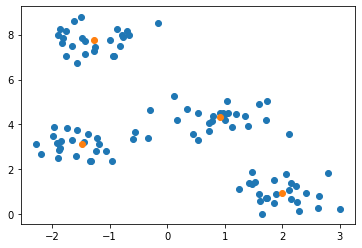

In [9]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.best_mu[:,0], kmeans.best_mu[:,1], marker='o')

## 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 $ k $ は人為的に決める必要がありますが、その判断方法としてエルボー法があります。  
エルボー法により中心点の個数 $ k $ を検討するためのコードを作成してください。  
SSEを縦軸、クラスタ数 $ k $ を横軸にした折れ線グラフを表示します。  
このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

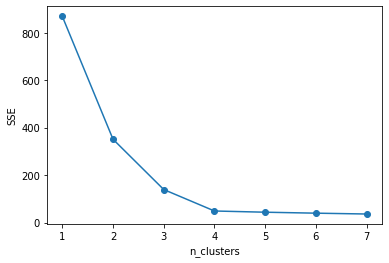

In [11]:
n_elbow = 7
score = np.zeros(n_elbow)
for i in range(n_elbow):
    kmeans = ScratchKMeans(n_clusters=i+1)
    kmeans.fit(X)
    score[i] = kmeans.best_sse
plt.plot(np.arange(n_elbow)+1, score, '-o')
plt.xlabel('n_clusters')
plt.ylabel('SSE')
plt.show();

## 【問題9】シルエット図
$ k $ を決める助けになるものとしてシルエット図もあります。  
シルエット図を表示するコードを作成してください。  
Matplotlibを使い図を表示するコードは用意しました。  
n番目のデータ点に対するシルエット係数 $ s_n $ は以下の数式でを求められます。  
この数式を実装し、シルエット図を確認してください。
$$
s_n = \frac{b_n-a_n}{max(b_n,a_n)}
$$

In [12]:
def calc_silhouette(X, mu, clusters):
    m = len(X)
    silhouette_vals = np.zeros(m)
    for i in range(m):
        a = np.mean(np.sum((X[clusters==clusters[i]]-X[i])**2, axis=1))
        mu_dist = np.sum((mu-mu[clusters[i]])**2, axis=1)
        idx = np.argsort(mu_dist)[1]
        b = np.mean(np.sum((X[clusters==idx]-X[i])**2, axis=1))
        silhouette_vals[i] = (b - a) / max(b, a)
    return silhouette_vals

In [13]:
from matplotlib import cm
def plot_silhouette(silhouette_vals, silhouette_avg, y_km, cluster_labels, n_clusters):
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()
#plot_silhouette(silhouette_vals, silhouette_avg, y_km, cluster_labels, n_clusters)

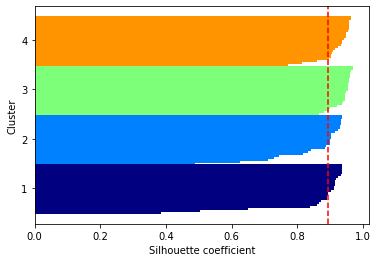

In [14]:
kmeans = ScratchKMeans(n_clusters=4)
kmeans.fit(X)

silhouette_vals = calc_silhouette(X, kmeans.best_mu, kmeans.best_clusters)
silhouette_avg = np.mean(silhouette_vals)
y_km = kmeans.best_clusters
cluster_labels = np.arange(kmeans.n_clusters)
n_clusters = kmeans.n_clusters
plot_silhouette(silhouette_vals, silhouette_avg, y_km, cluster_labels, n_clusters)

## 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 k を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。  
選択した上で、なぜそれを選んだか説明してください。

In [15]:
data = pd.read_csv('Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


[0.45961362 0.86478588 0.93481596 0.97883941 0.99386152 1.        ]


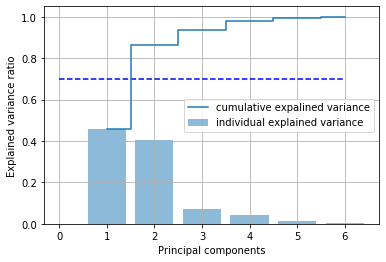

In [18]:
from sklearn.decomposition import PCA
NUM = 6
pca = PCA(n_components=NUM)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,NUM+1), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,NUM+1), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

PCAの結果では次元4で元データの分散の95%を維持できている。

In [19]:
data_dropped = data.drop(columns=['Region', 'Channel']).values

### RegionとChannel以外のデータでクラスタリング

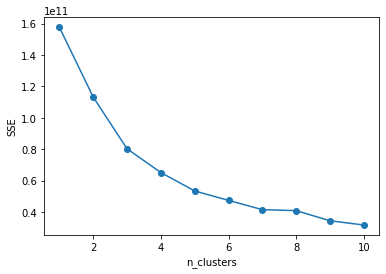

In [20]:
n = 10
score = np.zeros(n)
for i in range(n):
    kmeans = ScratchKMeans(n_clusters=i+1)
    kmeans.fit(data_dropped)
    score[i] = kmeans.best_sse
plt.plot(np.arange(n)+1, score, '-o')
plt.xlabel('n_clusters')
plt.ylabel('SSE')
plt.show();

エルボー図ではk=5, 6, 7, 8がよさそう。

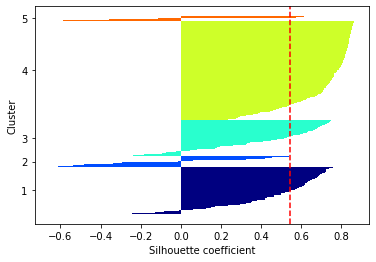

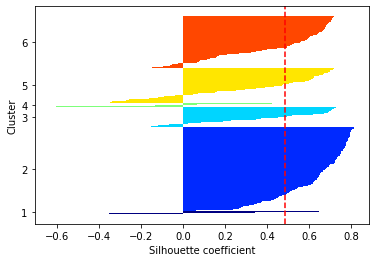

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


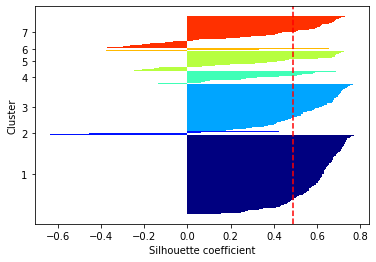

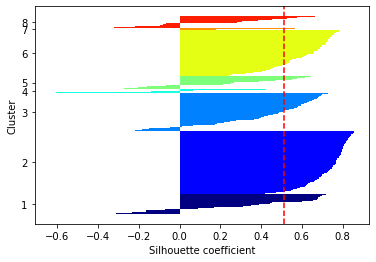

In [21]:
for i in [5, 6, 7, 8]:
    kmeans = ScratchKMeans(n_clusters=i)
    kmeans.fit(data_dropped)

    silhouette_vals = calc_silhouette(data_dropped, kmeans.best_mu, kmeans.best_clusters)
    silhouette_avg = np.mean(silhouette_vals)
    y_km = kmeans.best_clusters
    cluster_labels = np.arange(kmeans.n_clusters)
    n_clusters = kmeans.n_clusters
    plot_silhouette(silhouette_vals, silhouette_avg, y_km, cluster_labels, n_clusters)

シルエット図ではおおきな違いはなさそう。

### PCA処理後のデータでクラスタリング

In [22]:
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


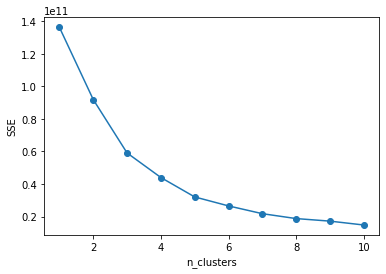

In [23]:
n = 10
score = np.zeros(n)
for i in range(n):
    kmeans = ScratchKMeans(n_clusters=i+1)
    kmeans.fit(data_pca)
    score[i] = kmeans.best_sse
plt.plot(np.arange(n)+1, score, '-o')
plt.xlabel('n_clusters')
plt.ylabel('SSE')
plt.show();

エルボー図ではk=5, 6, 7, 8がよさそう。

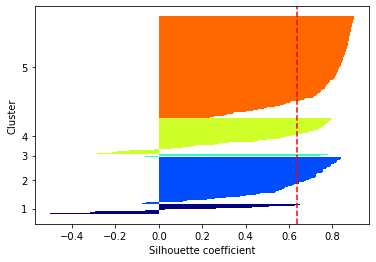

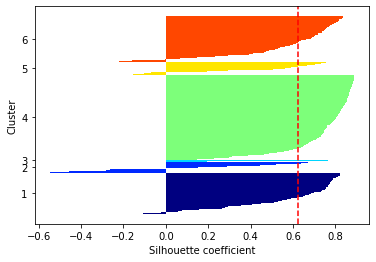

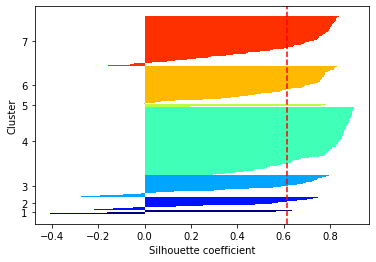

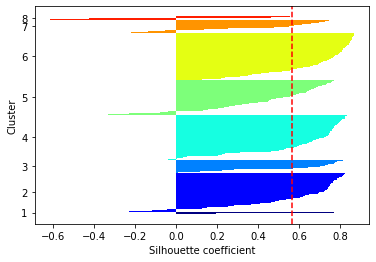

In [24]:
for i in [5, 6, 7, 8]:
    kmeans = ScratchKMeans(n_clusters=i)
    kmeans.fit(data_pca)

    silhouette_vals = calc_silhouette(data_pca, kmeans.best_mu, kmeans.best_clusters)
    silhouette_avg = np.mean(silhouette_vals)
    y_km = kmeans.best_clusters
    cluster_labels = np.arange(kmeans.n_clusters)
    n_clusters = kmeans.n_clusters
    plot_silhouette(silhouette_vals, silhouette_avg, y_km, cluster_labels, n_clusters)

シルエット図ではおおきな違いはなさそう。

In [43]:
#Channelの値
data['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

In [44]:
#Regionの値
data['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

クラスタ数は6とする。  
理由は、Channelは2値、Regionは3値からなる特徴量であり、これらの特徴量を組み合わせて6値に分類できると考えられるため。  
またデータは、Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassenの6つの特徴量から成るのでそれぞれのクラスタがそれぞれの列に対応づけられることが期待できるため。

## 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これらは既知のグループです。  
クラスタとこれらのグループがどう違うか確認し、説明してください。

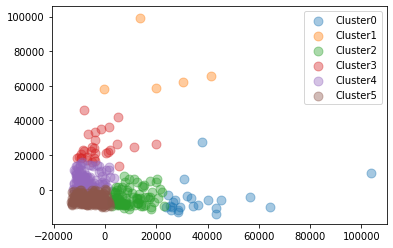

In [46]:
kmeans = ScratchKMeans(n_clusters=6)
kmeans.fit(data_pca)
y_pred = kmeans.predict(data_pca)
# plt.scatter(data_pca[data['Region']==1, 0], data_pca[data['Region']==1, 1], label='Region=1')
# plt.scatter(data_pca[data['Region']==2, 0], data_pca[data['Region']==2, 1], label='Region=2')
# plt.scatter(data_pca[data['Region']==3, 0], data_pca[data['Region']==3, 1], label='Region=3')
plt.scatter(data_pca[kmeans.clusters==0, 0], data_pca[kmeans.clusters==0, 1], label='Cluster0', s=80, alpha=0.4)
plt.scatter(data_pca[kmeans.clusters==1, 0], data_pca[kmeans.clusters==1, 1], label='Cluster1', s=80, alpha=0.4)
plt.scatter(data_pca[kmeans.clusters==2, 0], data_pca[kmeans.clusters==2, 1], label='Cluster2', s=80, alpha=0.4)
plt.scatter(data_pca[kmeans.clusters==3, 0], data_pca[kmeans.clusters==3, 1], label='Cluster3', s=80, alpha=0.4)
plt.scatter(data_pca[kmeans.clusters==4, 0], data_pca[kmeans.clusters==4, 1], label='Cluster4', s=80, alpha=0.4)
plt.scatter(data_pca[kmeans.clusters==5, 0], data_pca[kmeans.clusters==5, 1], label='Cluster5', s=80, alpha=0.4)
#plt.scatter(kmeans.best_mu[:,0], kmeans.best_mu[:,1], marker='o', label='cluster', c='r', s=100)
plt.legend();

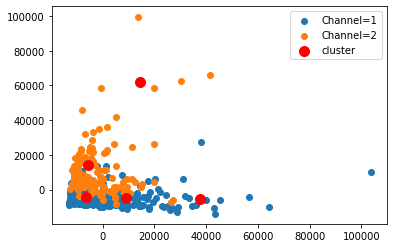

In [22]:
plt.scatter(data_pca[data['Channel']==1, 0], data_pca[data['Channel']==1, 1], label='Channel=1')
plt.scatter(data_pca[data['Channel']==2, 0], data_pca[data['Channel']==2, 1], label='Channel=2')
plt.scatter(kmeans.best_mu[:,0], kmeans.best_mu[:,1], marker='o', label='cluster', c='r', s=100)
plt.legend();

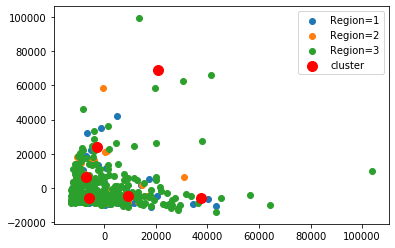

In [85]:
plt.scatter(data_pca[data['Region']==1, 0], data_pca[data['Region']==1, 1], label='Region=1')
plt.scatter(data_pca[data['Region']==2, 0], data_pca[data['Region']==2, 1], label='Region=2')
plt.scatter(data_pca[data['Region']==3, 0], data_pca[data['Region']==3, 1], label='Region=3')
plt.scatter(kmeans.best_mu[:,0], kmeans.best_mu[:,1], marker='o', label='cluster', c='r', s=100)
plt.legend();

Channel==1はcluster0,2,5に、Channel==2はcluster1,3,4に属する傾向がみえた。  
Regionについては傾向はみられなかった。

In [58]:
c1r1 = (data['Channel']==1) & (data['Region']==1)
c1r2 = (data['Channel']==1) & (data['Region']==2)
c1r3 = (data['Channel']==1) & (data['Region']==3)
c2r1 = (data['Channel']==2) & (data['Region']==1)
c2r2 = (data['Channel']==2) & (data['Region']==2)
c2r3 = (data['Channel']==2) & (data['Region']==3)

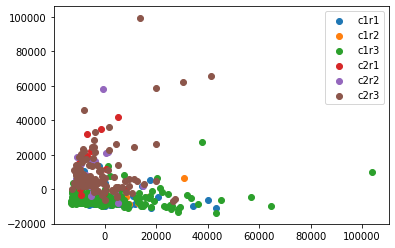

In [94]:
plt.scatter(data_pca[c1r1, 0], data_pca[c1r1, 1], label='c1r1')
plt.scatter(data_pca[c1r2, 0], data_pca[c1r2, 1], label='c1r2')
plt.scatter(data_pca[c1r3, 0], data_pca[c1r3, 1], label='c1r3')
plt.scatter(data_pca[c2r1, 0], data_pca[c2r1, 1], label='c2r1')
plt.scatter(data_pca[c2r2, 0], data_pca[c2r2, 1], label='c2r2')
plt.scatter(data_pca[c2r3, 0], data_pca[c2r3, 1], label='c2r3')
plt.legend();

## 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

In [97]:
data[['Fresh','Milk','Grocery','Frozen','Detergents_Paper', 'Delicassen']].describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


In [99]:
data.loc[c1r1,['Fresh','Milk','Grocery','Frozen','Detergents_Paper', 'Delicassen']].describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,59.0,12902.254237,12342.008901,514.0,4437.5,8656.0,18135.0,56083.0
Milk,59.0,3870.203390,4298.321195,258.0,1071.0,2280.0,4995.5,23527.0
Grocery,59.0,4026.135593,3629.644143,489.0,1620.0,2576.0,5172.5,16966.0
Frozen,59.0,3127.322034,3276.460124,91.0,966.0,1859.0,4479.0,18711.0
Detergents_Paper,59.0,950.525424,1305.907616,5.0,237.0,412.0,874.0,5828.0
Delicassen,59.0,1197.152542,1219.945304,7.0,374.0,749.0,1621.5,6854.0


Fresh, Frozen以外はあまり買わないグループ。

In [100]:
data.loc[c1r2,['Fresh','Milk','Grocery','Frozen','Detergents_Paper', 'Delicassen']].describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,28.0,11650.535714,8969.362752,3.0,4938.25,9787.0,17031.50,32717.0
Milk,28.0,2304.250000,2968.628697,333.0,1146.00,1560.5,2344.75,16784.0
Grocery,28.0,4395.500000,3048.298815,1330.0,2373.75,3352.0,5527.50,13626.0
Frozen,28.0,5745.035714,11454.478518,264.0,962.25,2696.5,4617.00,60869.0
Detergents_Paper,28.0,482.714286,425.310506,15.0,182.75,325.0,707.00,1679.0
Delicassen,28.0,1105.892857,1056.778800,51.0,567.25,883.0,1146.00,5609.0


Frozenをよく買う、Freshは平均程度、Milk, Grocery, Detergents_Paper, Dilicassenはかわないグループ。

In [101]:
data.loc[c1r3,['Fresh','Milk','Grocery','Frozen','Detergents_Paper', 'Delicassen']].describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,211.0,13878.052133,14746.572913,3.0,3702.5,9612.0,18821.0,112151.0
Milk,211.0,3486.981043,4508.505269,55.0,1188.5,2247.0,4205.0,43950.0
Grocery,211.0,3886.734597,3593.506056,3.0,1666.0,2642.0,4927.5,21042.0
Frozen,211.0,3656.900474,4956.590848,25.0,779.0,1960.0,4542.5,36534.0
Detergents_Paper,211.0,786.682464,1099.970640,3.0,176.5,375.0,948.5,6907.0
Delicassen,211.0,1518.284360,3663.183304,3.0,378.5,823.0,1582.0,47943.0


どの品も平均程度に買うグループ。一番多い。

In [102]:
data.loc[c2r1,['Fresh','Milk','Grocery','Frozen','Detergents_Paper', 'Delicassen']].describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,18.0,5200.000000,5415.521495,18.0,2378.25,2926.0,5988.00,20782.0
Milk,18.0,10784.000000,6609.221463,2527.0,6253.25,8866.0,13112.25,28326.0
Grocery,18.0,18471.944444,10414.687844,5265.0,10634.25,16106.0,23478.75,39694.0
Frozen,18.0,2584.111111,2424.774577,61.0,923.50,1522.0,3843.00,8321.0
Detergents_Paper,18.0,8225.277778,5515.878798,788.0,4818.25,6177.0,11804.75,19410.0
Delicassen,18.0,1871.944444,1626.486667,120.0,746.00,1414.0,2456.50,6372.0


Milk, Grocery, Detergents_Paperをよく買うグループ。

In [103]:
data.loc[c2r2,['Fresh','Milk','Grocery','Frozen','Detergents_Paper', 'Delicassen']].describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,19.0,7289.789474,6867.934548,161.0,2368.0,6468.0,9162.0,27082.0
Milk,19.0,9190.789474,6611.354136,928.0,4148.5,6817.0,13127.5,25071.0
Grocery,19.0,16326.315789,14035.453775,2743.0,9318.5,12469.0,19785.5,67298.0
Frozen,19.0,1540.578947,2473.266471,131.0,639.5,934.0,1410.0,11559.0
Detergents_Paper,19.0,8410.263158,8286.748255,332.0,3900.0,6236.0,9837.5,38102.0
Delicassen,19.0,1239.000000,1065.438042,59.0,392.5,1037.0,1815.0,3508.0


Grocery, Detergents_Paperをよく買うグループ。

In [104]:
data.loc[c2r3,['Fresh','Milk','Grocery','Frozen','Detergents_Paper', 'Delicassen']].describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,105.0,9831.504762,9635.394129,23.0,2343.0,7362.0,15076.0,44466.0
Milk,105.0,10981.009524,10574.827178,1124.0,6128.0,7845.0,11114.0,73498.0
Grocery,105.0,15953.809524,12298.935356,4523.0,9170.0,12121.0,19805.0,92780.0
Frozen,105.0,1513.200000,1504.498737,33.0,437.0,1059.0,2194.0,8132.0
Detergents_Paper,105.0,6899.238095,6022.091110,523.0,3537.0,5121.0,7677.0,40827.0
Delicassen,105.0,1826.209524,2119.052222,3.0,545.0,1386.0,2158.0,16523.0


Milk, Grocery, Detergents_Paperをよく買うグループ。  
全体の25％程度で2番目に多い。

#### DBSCAN

In [26]:
from sklearn import cluster, mixture, datasets

In [27]:
dataset1 = datasets.make_blobs(n_samples=1000, random_state=10, centers=6, cluster_std=1.2)[0]
dataset2 = datasets.make_moons(n_samples=1000, noise=0.05)[0]

In [28]:
def cluster_plots(set1, set2, colours1 = 'gray', colours2 = 'gray', title1 = 'Dataset 1', title2 = 'Dataset 2'):
 
    fig,(ax1,ax2) = plt.subplots(1, 2)
    fig.set_size_inches(6, 3)
 
    ax1.set_title(title1,fontsize=14)
    ax1.set_xlim(min(set1[:,0]), max(set1[:,0]))
    ax1.set_ylim(min(set1[:,1]), max(set1[:,1]))
    ax1.scatter(set1[:, 0], set1[:, 1],s=8,lw=0,c= colours1)
 
    ax2.set_title(title2,fontsize=14)
    ax2.set_xlim(min(set2[:,0]), max(set2[:,0]))
    ax2.set_ylim(min(set2[:,1]), max(set2[:,1]))
    ax2.scatter(set2[:, 0], set2[:, 1],s=8,lw=0,c=colours2)
 
    fig.tight_layout()
    plt.show()

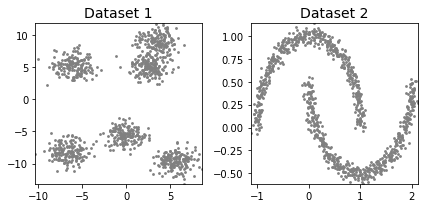

In [29]:
cluster_plots(dataset1,  dataset2)

In [30]:
dbscan_dataset1 = cluster.DBSCAN(eps=1, min_samples=5, metric='euclidean').fit_predict(dataset1)
dbscan_dataset2 = cluster.DBSCAN(eps=1, min_samples=5, metric='euclidean').fit_predict(dataset2)

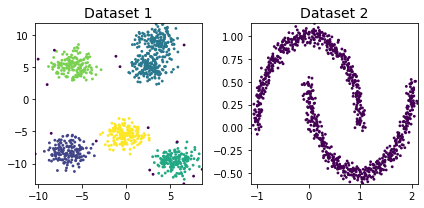

In [31]:
cluster_plots(dataset1, dataset2, dbscan_dataset1, dbscan_dataset2)

In [32]:
dbscan_dataset1 = cluster.DBSCAN(eps=0.1, min_samples=5, metric='euclidean').fit_predict(dataset1)
dbscan_dataset2 = cluster.DBSCAN(eps=0.1, min_samples=5, metric='euclidean').fit_predict(dataset2)

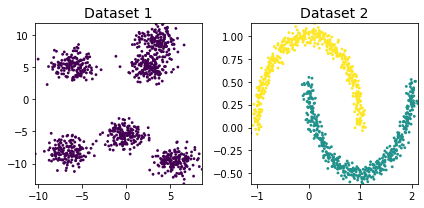

In [33]:
cluster_plots(dataset1, dataset2, dbscan_dataset1, dbscan_dataset2)

In [34]:
np.sum(dbscan_dataset1==-1)

1000